# Exploratory Data Analysis

In [58]:
import pandas as pd
import numpy as np 
import json
import requests
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore
from scipy import stats

In [59]:
#load dataframe created in data wrangling phase
#parse datetime column
df=pd.read_csv('cleaned_cov_weather3.csv', parse_dates=[0])

In [60]:
df.head()

,date,vt_avg_temp,vt_prcp,me_avg_temp,me_prcp,ct_avg_temp,ct_prcp,ma_avg_temp,ma_prcp,CT_conf_cases,ME_conf_cases,MA_conf_cases,VT_conf_cases
0,2020-01-22,-28,0,-72.0,0.0,-76.0,0.0,-53.0,0.0,0,0,0,0
1,2020-01-23,-27,0,-30.0,3.0,-46.0,0.0,0.0,0.0,0,0,0,0
2,2020-01-24,-8,0,-14.0,0.0,6.0,0.0,19.0,0.0,0,0,0,0
3,2020-01-25,3,119,-30.0,3.0,23.0,218.0,33.0,25.0,0,0,0,0
4,2020-01-26,22,23,11.0,132.0,49.0,0.0,64.0,193.0,0,0,0,0


In [61]:
#double check data types
df.dtypes

date             datetime64[ns]
vt_avg_temp               int64
vt_prcp                   int64
me_avg_temp             float64
me_prcp                 float64
ct_avg_temp             float64
ct_prcp                 float64
ma_avg_temp             float64
ma_prcp                 float64
CT_conf_cases             int64
ME_conf_cases             int64
MA_conf_cases             int64
VT_conf_cases             int64
dtype: object

In [62]:
#Convert int columns to float in preparation for calculations:
int_columns= {"CT_conf_cases": 'float', "ME_conf_cases": 'float', "MA_conf_cases":"float", "VT_conf_cases":'float', "vt_avg_temp":'float', "vt_prcp":'float'}
df = df.astype(int_columns)

In [63]:
df.dtypes

date             datetime64[ns]
vt_avg_temp             float64
vt_prcp                 float64
me_avg_temp             float64
me_prcp                 float64
ct_avg_temp             float64
ct_prcp                 float64
ma_avg_temp             float64
ma_prcp                 float64
CT_conf_cases           float64
ME_conf_cases           float64
MA_conf_cases           float64
VT_conf_cases           float64
dtype: object

In [64]:
#Any missing values?
df[pd.isnull(df).any(axis=1)]

,date,vt_avg_temp,vt_prcp,me_avg_temp,me_prcp,ct_avg_temp,ct_prcp,ma_avg_temp,ma_prcp,CT_conf_cases,ME_conf_cases,MA_conf_cases,VT_conf_cases


No missing values.

However, the units of TAVG and PRCP are clearly off. 

According to [NOAA documentation](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt), temperatures are reported in __*tenths*__ of a degree Celsius. I'll convert to degrees Fahrenheit instead (since this is US data here).

In [65]:
# (C*9/50)+32=F (since C is reported here as tenths of degrees)
df2 = df
state_temp_cols = ['vt_avg_temp', 'me_avg_temp', 'ct_avg_temp', 'ma_avg_temp']
for col in state_temp_cols:
    df2[col] = ((df[col]*9)/50) + 32

In [66]:
df2.head()

,date,vt_avg_temp,vt_prcp,me_avg_temp,me_prcp,ct_avg_temp,ct_prcp,ma_avg_temp,ma_prcp,CT_conf_cases,ME_conf_cases,MA_conf_cases,VT_conf_cases
0,2020-01-22,26.96,0.0,19.04,0.0,18.32,0.0,22.46,0.0,0.0,0.0,0.0,0.0
1,2020-01-23,27.14,0.0,26.60,3.0,23.72,0.0,32.00,0.0,0.0,0.0,0.0,0.0
2,2020-01-24,30.56,0.0,29.48,0.0,33.08,0.0,35.42,0.0,0.0,0.0,0.0,0.0
3,2020-01-25,32.54,119.0,26.60,3.0,36.14,218.0,37.94,25.0,0.0,0.0,0.0,0.0
4,2020-01-26,35.96,23.0,33.98,132.0,40.82,0.0,43.52,193.0,0.0,0.0,0.0,0.0


The [same documention](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) cited above also explains that PRCP data is reported in __*tenths*__ of a mm. [Wikipedia](https://en.wikipedia.org/wiki/Precipitation) reports that generally PRCP data is reported in millimeters, so I'll convert to millimeters instead.

In [67]:
df3 = df2
state_prcp_cols = ['vt_prcp', 'me_prcp', 'ct_prcp', 'ma_prcp']
for col in state_prcp_cols:
    df3[col] = df2[col]/10

In [68]:
df3.head()

,date,vt_avg_temp,vt_prcp,me_avg_temp,me_prcp,ct_avg_temp,ct_prcp,ma_avg_temp,ma_prcp,CT_conf_cases,ME_conf_cases,MA_conf_cases,VT_conf_cases
0,2020-01-22,26.96,0.0,19.04,0.0,18.32,0.0,22.46,0.0,0.0,0.0,0.0,0.0
1,2020-01-23,27.14,0.0,26.60,0.3,23.72,0.0,32.00,0.0,0.0,0.0,0.0,0.0
2,2020-01-24,30.56,0.0,29.48,0.0,33.08,0.0,35.42,0.0,0.0,0.0,0.0,0.0
3,2020-01-25,32.54,11.9,26.60,0.3,36.14,21.8,37.94,2.5,0.0,0.0,0.0,0.0
4,2020-01-26,35.96,2.3,33.98,13.2,40.82,0.0,43.52,19.3,0.0,0.0,0.0,0.0


For the sake of clarity, I'll update column names to reflect this unit change.

In [69]:
#Update column names to reflect new units:
units_dict= {'vt_avg_temp': 'VT_Avg_Temp(F)', 'vt_prcp': 'VT_PRCP(mm)', 'me_avg_temp':'ME_Avg_Temp(F)', 'me_prcp': 'ME_PRCP(mm)', 'ct_avg_temp': 'CT_Avg_Temp(F)', 'ct_prcp':'CT_PRCP(mm)', 'ma_avg_temp': 'MA_Avg_Temp(F)', 'ma_prcp':'MA_PRCP(mm)'}
df3.rename(columns=units_dict, inplace=True)
df3.head()

,date,VT_Avg_Temp(F),VT_PRCP(mm),ME_Avg_Temp(F),ME_PRCP(mm),CT_Avg_Temp(F),CT_PRCP(mm),MA_Avg_Temp(F),MA_PRCP(mm),CT_conf_cases,ME_conf_cases,MA_conf_cases,VT_conf_cases
0,2020-01-22,26.96,0.0,19.04,0.0,18.32,0.0,22.46,0.0,0.0,0.0,0.0,0.0
1,2020-01-23,27.14,0.0,26.60,0.3,23.72,0.0,32.00,0.0,0.0,0.0,0.0,0.0
2,2020-01-24,30.56,0.0,29.48,0.0,33.08,0.0,35.42,0.0,0.0,0.0,0.0,0.0
3,2020-01-25,32.54,11.9,26.60,0.3,36.14,21.8,37.94,2.5,0.0,0.0,0.0,0.0
4,2020-01-26,35.96,2.3,33.98,13.2,40.82,0.0,43.52,19.3,0.0,0.0,0.0,0.0


In [70]:
#Examine timespan of data:
print('Beginning date: ',min(df3['date']))
print('End date: ', max(df3['date']))
print('Total timespan: ', max(df3['date']-min(df3['date'])))

Beginning date:  2020-01-22 00:00:00
End date:  2021-09-12 00:00:00
Total timespan:  599 days 00:00:00


In [71]:
# Make copy of df 
df4=df3

In [72]:
# Make column of non-cumulative counts of confirmed cases for each state:
df4["CT_Conf_Cases"] = df4['CT_conf_cases'].diff().fillna(0)
df4["VT_Conf_Cases"] = df4['VT_conf_cases'].diff().fillna(0)
df4["ME_Conf_Cases"] = df4['ME_conf_cases'].diff().fillna(0)
df4["MA_Conf_Cases"] = df4['MA_conf_cases'].diff().fillna(0)

In [73]:
#Drop cumulative confirmed case columns:
df5 = df4.drop(columns=['CT_conf_cases', 'VT_conf_cases', 'ME_conf_cases', 'MA_conf_cases'])

In [74]:
#Reset DateTimeIndex
df5.set_index('date',inplace=True)
df5

,VT_Avg_Temp(F),VT_PRCP(mm),ME_Avg_Temp(F),ME_PRCP(mm),CT_Avg_Temp(F),CT_PRCP(mm),MA_Avg_Temp(F),MA_PRCP(mm),CT_Conf_Cases,VT_Conf_Cases,ME_Conf_Cases,MA_Conf_Cases
date,,,,,,,,,,,,
2020-01-22,26.96,0.0,19.04,0.0,18.32,0.0,22.46,0.0,0.0,0.0,0.0,0.0
2020-01-23,27.14,0.0,26.60,0.3,23.72,0.0,32.00,0.0,0.0,0.0,0.0,0.0
2020-01-24,30.56,0.0,29.48,0.0,33.08,0.0,35.42,0.0,0.0,0.0,0.0,0.0
2020-01-25,32.54,11.9,26.60,0.3,36.14,21.8,37.94,2.5,0.0,0.0,0.0,0.0
2020-01-26,35.96,2.3,33.98,13.2,40.82,0.0,43.52,19.3,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-08,72.86,24.1,63.50,0.0,70.16,0.0,71.96,0.0,219.0,0.0,4.0,260.0
2021-09-09,67.46,0.0,62.42,35.3,71.42,3.8,70.88,8.1,136.0,0.0,1.0,364.0
2021-09-10,59.90,0.5,58.46,13.0,66.92,0.0,68.54,0.0,151.0,4.0,2.0,307.0


In [75]:
#Take a look at some summary statistics of the data:
df5.describe()

,VT_Avg_Temp(F),VT_PRCP(mm),ME_Avg_Temp(F),ME_PRCP(mm),CT_Avg_Temp(F),CT_PRCP(mm),MA_Avg_Temp(F),MA_PRCP(mm),CT_Conf_Cases,VT_Conf_Cases,ME_Conf_Cases,MA_Conf_Cases
count,604.000000,604.000000,604.000000,604.000000,604.000000,604.000000,604.000000,604.000000,604.000000,604.000000,604.000000,604.000000
mean,51.046325,2.253146,45.169205,2.917881,54.173974,3.558278,54.302864,3.770364,153.082781,0.561258,1.387417,243.678808
std,19.888186,5.818653,19.495882,9.129633,17.492540,10.199061,16.923667,10.274149,282.454046,1.337514,3.098532,300.012813
min,2.120000,0.000000,-1.840000,0.000000,11.660000,0.000000,14.000000,0.000000,-7.000000,-2.000000,-5.000000,-69.000000
25%,35.060000,0.000000,30.020000,0.000000,39.200000,0.000000,40.325000,0.000000,0.000000,0.000000,0.000000,30.750000
50%,51.440000,0.000000,46.490000,0.000000,55.490000,0.000000,54.500000,0.000000,45.500000,0.000000,0.000000,128.000000
75%,68.000000,1.300000,62.060000,1.300000,70.160000,1.300000,68.540000,2.000000,178.250000,1.000000,2.000000,346.250000
max,84.920000,63.500000,80.060000,131.100000,85.640000,103.400000,87.980000,95.000000,2336.000000,15.000000,37.000000,1607.000000


It looks like some of the states have `Conf_Cases` values that are less than zero (see `min` row). That can't be right; I'll replace them with zeroes instead.

In [76]:
#Replace negative values with zeroes:
df5[df5 < 0] = 0

A quick look at the tail of the DataFrame reveals another interesting detail:

In [77]:
df5['CT_Conf_Cases'].tail(25)

date
2021-08-19    139.0
2021-08-20    118.0
2021-08-21      0.0
2021-08-22      0.0
2021-08-23    453.0
2021-08-24    188.0
2021-08-25    124.0
2021-08-26    202.0
2021-08-27    224.0
2021-08-28      0.0
2021-08-29      0.0
2021-08-30    339.0
2021-08-31    307.0
2021-09-01    266.0
2021-09-02    185.0
2021-09-03    196.0
2021-09-04      0.0
2021-09-05      0.0
2021-09-06      0.0
2021-09-07    385.0
2021-09-08    219.0
2021-09-09    136.0
2021-09-10    151.0
2021-09-11      0.0
2021-09-12      0.0
Name: CT_Conf_Cases, dtype: float64

It looks like, for every five days of values for `Conf_Cases`, there are two days of zero values. A quick calendar check confirms that the dates corresponding to zero values are weekend dates (besides 09/06/21, which was Labor Day- a bank holiday in the US). Because there is only data for weekdays, I'll remove weekend data, as it can only skew our summary statistics and plots.

In [78]:
#Create column to designate day of week:
df6= df5
df6["weekday"] = df6.index.dayofweek

In [79]:
#Filter DataFrame to only include weekdays (days 0-4)
df6 = df6[(df6.weekday != 5) & (df6.weekday != 6)]

Another quick check of the summary statistics:

In [80]:
df6.describe()

,VT_Avg_Temp(F),VT_PRCP(mm),ME_Avg_Temp(F),ME_PRCP(mm),CT_Avg_Temp(F),CT_PRCP(mm),MA_Avg_Temp(F),MA_PRCP(mm),CT_Conf_Cases,VT_Conf_Cases,ME_Conf_Cases,MA_Conf_Cases,weekday
count,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,51.333427,2.384848,45.444709,2.994639,54.555804,3.922378,54.657343,3.974359,205.839161,0.596737,1.484848,253.508159,2.002331
std,19.754565,5.967649,19.565369,8.002695,17.305070,10.723063,16.845749,10.670719,314.810705,1.388568,3.258042,292.049442,1.416688
min,2.120000,0.000000,0.000000,0.000000,13.100000,0.000000,17.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.060000,0.000000,30.020000,0.000000,39.380000,0.000000,40.460000,0.000000,29.000000,0.000000,0.000000,45.000000,1.000000
50%,51.980000,0.000000,46.940000,0.000000,55.760000,0.000000,55.400000,0.000000,110.000000,0.000000,0.000000,153.000000,2.000000
75%,68.000000,1.300000,62.420000,1.800000,70.160000,1.800000,68.540000,2.500000,236.000000,1.000000,2.000000,364.000000,3.000000
max,84.920000,63.500000,80.060000,68.800000,85.640000,103.400000,87.980000,95.000000,2336.000000,15.000000,37.000000,1460.000000,4.000000


In [81]:
df6.head()

,VT_Avg_Temp(F),VT_PRCP(mm),ME_Avg_Temp(F),ME_PRCP(mm),CT_Avg_Temp(F),CT_PRCP(mm),MA_Avg_Temp(F),MA_PRCP(mm),CT_Conf_Cases,VT_Conf_Cases,ME_Conf_Cases,MA_Conf_Cases,weekday
date,,,,,,,,,,,,,
2020-01-22,26.96,0.0,19.04,0.0,18.32,0.0,22.46,0.0,0.0,0.0,0.0,0.0,2
2020-01-23,27.14,0.0,26.60,0.3,23.72,0.0,32.00,0.0,0.0,0.0,0.0,0.0,3
2020-01-24,30.56,0.0,29.48,0.0,33.08,0.0,35.42,0.0,0.0,0.0,0.0,0.0,4
2020-01-27,34.52,1.3,31.46,1.0,38.84,0.0,39.02,0.0,0.0,0.0,0.0,0.0,0
2020-01-28,30.02,0.3,21.56,0.0,36.68,0.0,37.40,0.0,0.0,0.0,0.0,0.0,1


In [82]:
#Create a list of US bank holidays in 2020-2021:
#Please refer to note below, explaining how this list of dates was put together.
US_bank_holidays = ['2020-02-17', '2020-12-25', '2020-11-26', '2020-12-25', '2021-01-01', '2021-05-31', '2021-09-06']

Full list of 2020 US Holidays [here](https://www.officeholidays.com/countries/usa/2020).
Full list of 2021 US Holidays [here](https://www.officeholidays.com/countries/usa/2021).\
__Note:__ Not all bank holidays listed in the above resources appear in my `US_bank_holidays` list. I used the resources above as a general guide of dates that might not contain any data, and then checked each of the dates individually to make sure I wasn't deleting any significant data from the set. I found that data __was__ recorded for some of the bank holidays listed in the resources; whenever this was the case, I did __not__ drop that row of data. The dates listed in `US_bank_holidays` reflect only those bank holidays listed in these resources that I was __also__ able to confirm did not have any significant data.

In [83]:
#Drop rows with indices in US_bank_holidays list:
df7= df6.drop(df6[(df6.index.isin(US_bank_holidays))].index)

In [84]:
#Check rows have been dropped:
print(len(df6.index))
print(len(df7.index))

429
423


In [85]:
#Recheck summary statistics with dropped US_bank_holidays:
df7.describe()

,VT_Avg_Temp(F),VT_PRCP(mm),ME_Avg_Temp(F),ME_PRCP(mm),CT_Avg_Temp(F),CT_PRCP(mm),MA_Avg_Temp(F),MA_PRCP(mm),CT_Conf_Cases,VT_Conf_Cases,ME_Conf_Cases,MA_Conf_Cases,weekday
count,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000
mean,51.429362,2.330733,45.537967,2.791962,54.633617,3.781087,54.708936,3.908747,208.758865,0.602837,1.496454,257.104019,2.004728
std,19.802337,5.938983,19.588555,7.352714,17.345304,10.476999,16.882002,10.640791,316.075796,1.396744,3.278446,292.538665,1.409170
min,2.120000,0.000000,0.000000,0.000000,13.100000,0.000000,17.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.060000,0.000000,30.020000,0.000000,39.380000,0.000000,40.460000,0.000000,30.000000,0.000000,0.000000,47.000000,1.000000
50%,51.980000,0.000000,46.940000,0.000000,55.760000,0.000000,55.400000,0.000000,112.000000,0.000000,0.000000,155.000000,2.000000
75%,68.180000,1.300000,62.690000,1.500000,70.160000,1.800000,68.720000,2.400000,237.500000,1.000000,2.000000,368.500000,3.000000
max,84.920000,63.500000,80.060000,58.200000,85.640000,103.400000,87.980000,95.000000,2336.000000,15.000000,37.000000,1460.000000,4.000000


## Plots:

With so many twin axes to plot, I'll define a function to help plot all of twin axes time series data:

In [86]:
def plot_timeseries(axes, x, y, color, xlabel, ylabel):
    axes.plot(x,y,color=color)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.tick_params('y', colors = color)

## Connecticut

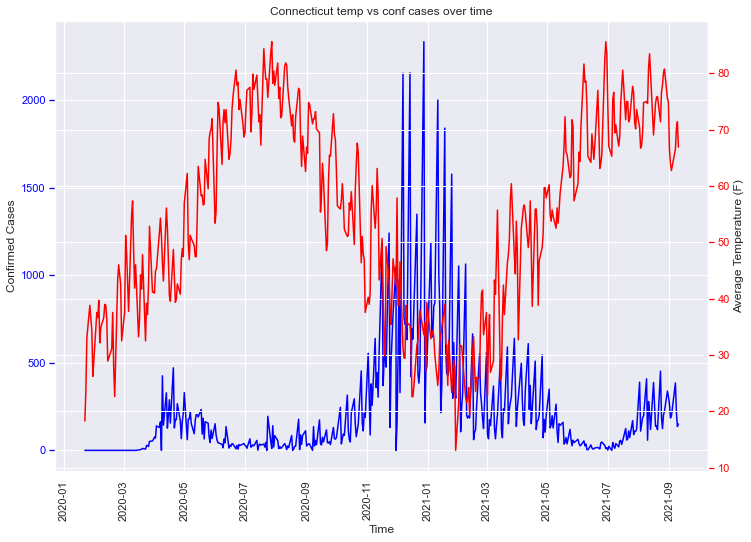

In [87]:
#Plot CT time vs confirmed cases
fig, ax = plt.subplots()
plot_timeseries(ax, df7.index, df7['CT_Conf_Cases'], 'blue', 'Time', 'Confirmed Cases')
plt.xticks(rotation=90)
ax2 = ax.twinx()
#Plot CT temp vs time
plot_timeseries(ax2, df7.index, df7['CT_Avg_Temp(F)'], 'red', 'Time', 'Average Temperature (F)')
plt.title('Connecticut temp vs conf cases over time')
plt.xticks(rotation=90)
plt.savefig('CT_temp.png', dpi=72, bbox_inches='tight')
plt.show()

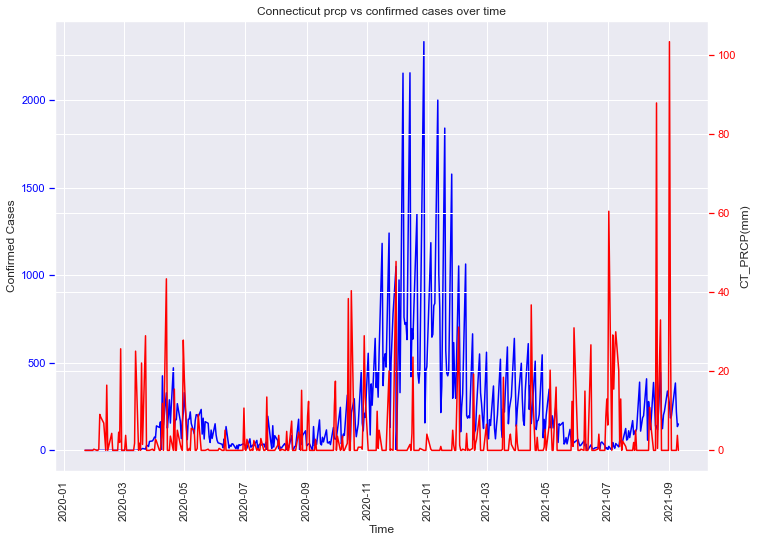

In [88]:
#Plot CT time vs confirmed cases
fig, ax = plt.subplots()
plot_timeseries(ax, df7.index, df7['CT_Conf_Cases'], 'blue', 'Time', 'Confirmed Cases')
plt.xticks(rotation=90)
ax2 = ax.twinx()
#Plot CT prcp vs time
plot_timeseries(ax2, df7.index, df7['CT_PRCP(mm)'], 'red', 'Time', 'CT_PRCP(mm)')
plt.title('Connecticut prcp vs confirmed cases over time')
plt.xticks(rotation=90)
plt.savefig('CT_prcp.png', dpi=72, bbox_inches='tight')
plt.show()

***

## Maine

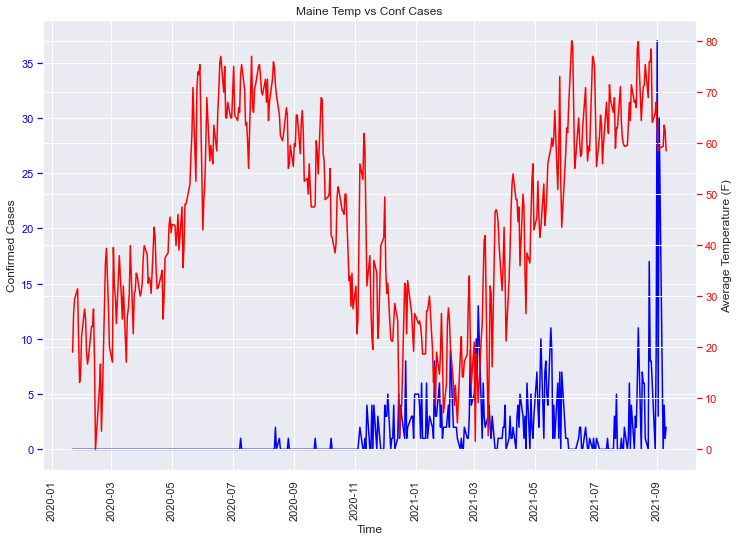

In [89]:
#Plot ME time vs Avg. Temp 
fig, ax = plt.subplots()
plot_timeseries(ax, df7.index, df7['ME_Conf_Cases'], 'blue', 'Time', 'Confirmed Cases')
plt.xticks(rotation=90)
ax2 = ax.twinx()
plot_timeseries(ax2, df7.index, df7['ME_Avg_Temp(F)'], 'red', 'Time', 'Average Temperature (F)')
plt.title('Maine Temp vs Conf Cases')
plt.xticks(rotation=90)
plt.savefig('ME_temp.png', dpi=72, bbox_inches='tight')
plt.show()

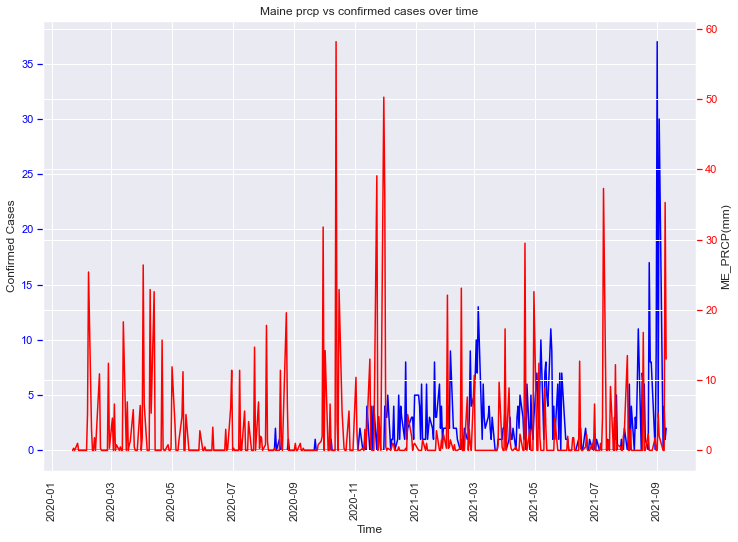

In [90]:
#Plot ME time vs confirmed cases
fig, ax = plt.subplots()
plot_timeseries(ax, df7.index, df7['ME_Conf_Cases'], 'blue', 'Time', 'Confirmed Cases')
plt.xticks(rotation=90)
ax2 = ax.twinx()
#Plot ME prcp vs time
plot_timeseries(ax2, df7.index, df7['ME_PRCP(mm)'], 'red', 'Time', 'ME_PRCP(mm)')
plt.title('Maine prcp vs confirmed cases over time')
plt.xticks(rotation=90)
plt.savefig('ME_prcp.png', dpi=72, bbox_inches='tight')
plt.show()

## Massachusetts

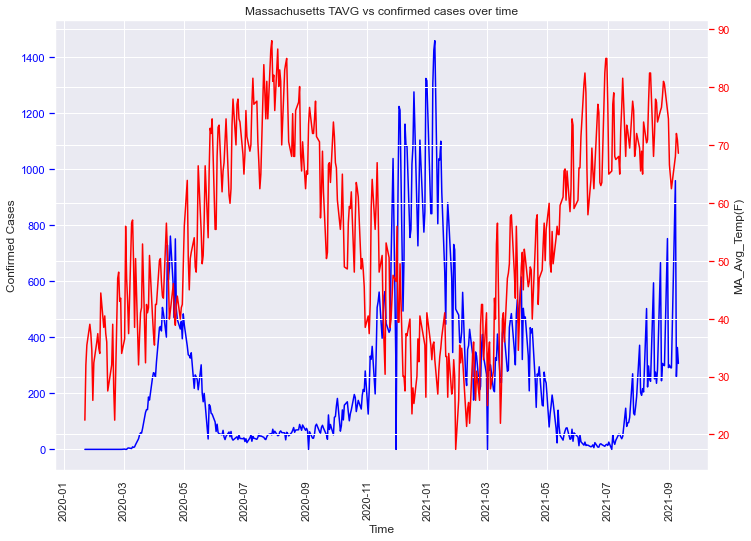

In [91]:
#Plot MA time vs confirmed cases
fig, ax = plt.subplots()
plot_timeseries(ax, df7.index, df7['MA_Conf_Cases'], 'blue', 'Time', 'Confirmed Cases')
plt.xticks(rotation=90)
ax2 = ax.twinx()
#Plot MA temp vs time
plot_timeseries(ax2, df7.index, df7['MA_Avg_Temp(F)'], 'red', 'Time', 'MA_Avg_Temp(F)')
plt.title('Massachusetts TAVG vs confirmed cases over time')
plt.xticks(rotation=90)
plt.show()

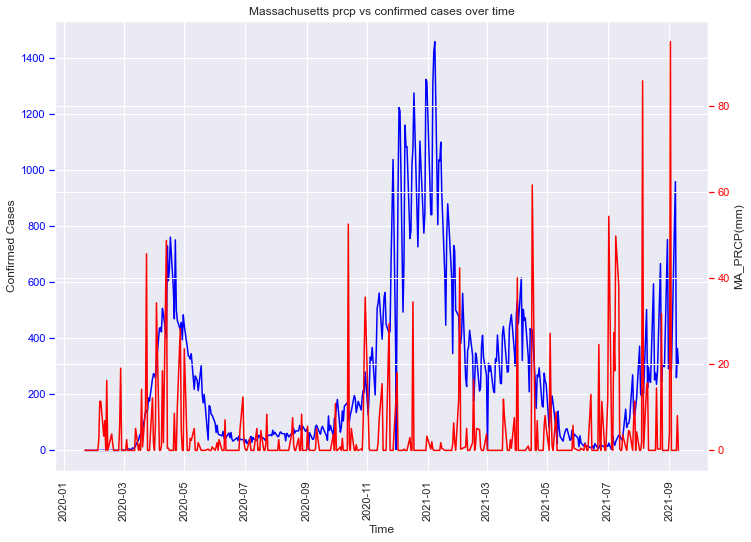

In [92]:
#Plot MA time vs confirmed cases
fig, ax = plt.subplots()
plot_timeseries(ax, df7.index, df7['MA_Conf_Cases'], 'blue', 'Time', 'Confirmed Cases')
plt.xticks(rotation=90)
ax2 = ax.twinx()
#Plot MA prcp vs time
plot_timeseries(ax2, df7.index, df7['MA_PRCP(mm)'], 'red', 'Time', 'MA_PRCP(mm)')
plt.title('Massachusetts prcp vs confirmed cases over time')
plt.xticks(rotation=90)
plt.show()

## Vermont

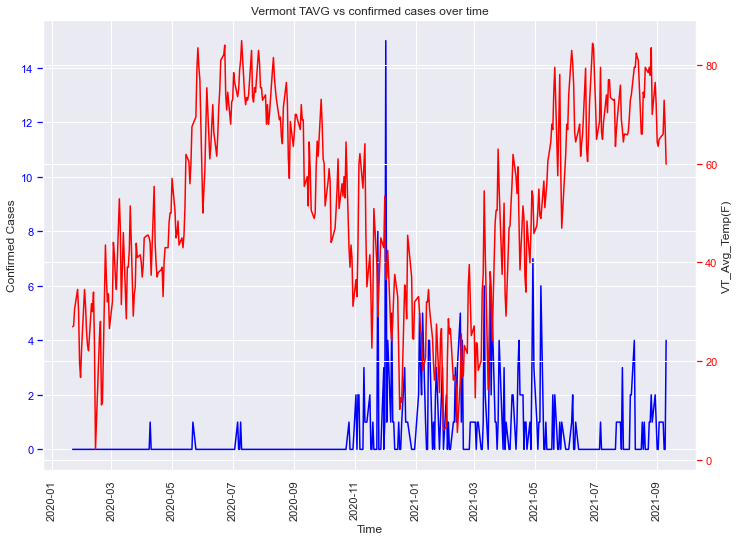

In [93]:
#Plot VT time vs confirmed cases
fig, ax = plt.subplots()
plot_timeseries(ax, df7.index, df7['VT_Conf_Cases'], 'blue', 'Time', 'Confirmed Cases')
plt.xticks(rotation=90)
ax2 = ax.twinx()
#Plot VT temp vs time
plot_timeseries(ax2, df7.index, df7['VT_Avg_Temp(F)'], 'red', 'Time', 'VT_Avg_Temp(F)')
plt.title('Vermont TAVG vs confirmed cases over time')
plt.xticks(rotation=90)
plt.show()

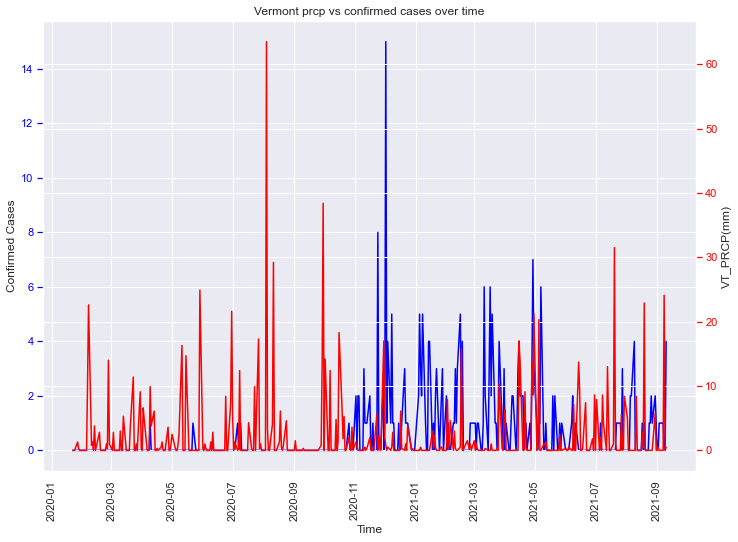

In [94]:
#Plot VT time vs confirmed cases
fig, ax = plt.subplots()
plot_timeseries(ax, df7.index, df7['VT_Conf_Cases'], 'blue', 'Time', 'Confirmed Cases')
plt.xticks(rotation=90)
ax2 = ax.twinx()
#Plot MA prcp vs time
plot_timeseries(ax2, df7.index, df7['VT_PRCP(mm)'], 'red', 'Time', 'VT_PRCP(mm)')
plt.title('Vermont prcp vs confirmed cases over time')
plt.xticks(rotation=90)
plt.show()

## Perform Shapiro-Wilk test for normality:

In [95]:
#Convert dataframe to array to perform Shapiro-Wilcox test:
np_cov_weather7 = df7.to_numpy()

In [96]:
#Apply Shapiro test:
shapiro_test = stats.shapiro(np_cov_weather7)

/Users/abigailmorgan/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [97]:
#Print values:
print("Shapiro test statistic is: ", shapiro_test.statistic)
print("Shapiro p-value is: ", shapiro_test.pvalue)

Shapiro test statistic is:  0.36322474479675293
Shapiro p-value is:  0.0


## Predictive Power Score:

In [98]:
#Calculate ppscore 
pps = ppscore.matrix(df7)

In [99]:
print(pps)

                  x               y   ppscore            case  is_valid_score  \
0    VT_Avg_Temp(F)  VT_Avg_Temp(F)  1.000000  predict_itself            True   
1    VT_Avg_Temp(F)     VT_PRCP(mm)  0.000000      regression            True   
2    VT_Avg_Temp(F)  ME_Avg_Temp(F)  0.776164      regression            True   
3    VT_Avg_Temp(F)     ME_PRCP(mm)  0.000000      regression            True   
4    VT_Avg_Temp(F)  CT_Avg_Temp(F)  0.695089      regression            True   
..              ...             ...       ...             ...             ...   
164         weekday   CT_Conf_Cases  0.000000      regression            True   
165         weekday   VT_Conf_Cases  0.000000      regression            True   
166         weekday   ME_Conf_Cases  0.000000      regression            True   
167         weekday   MA_Conf_Cases  0.000000      regression            True   
168         weekday         weekday  1.000000  predict_itself            True   

                  metric  b

In [100]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

<AxesSubplot:>

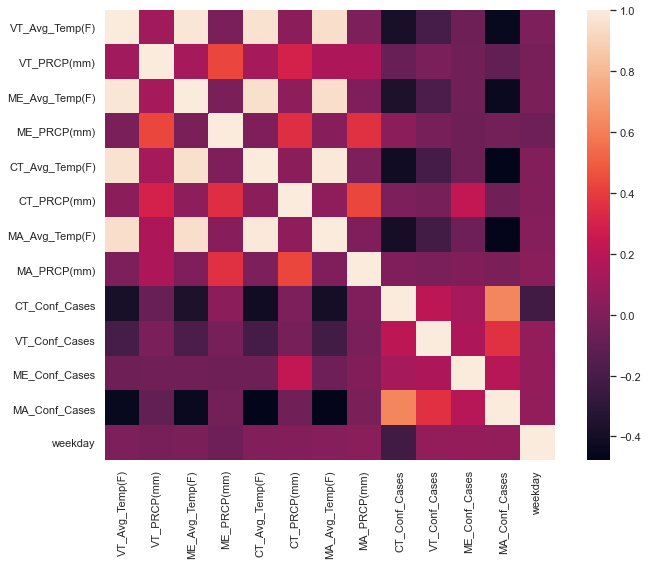

In [101]:
sns.heatmap(df7.corr(), square=True, cmap='rocket')

In [102]:
Hartford_CT = df7[['CT_Avg_Temp(F)', 'CT_PRCP(mm)', 'CT_Conf_Cases']]

<AxesSubplot:>

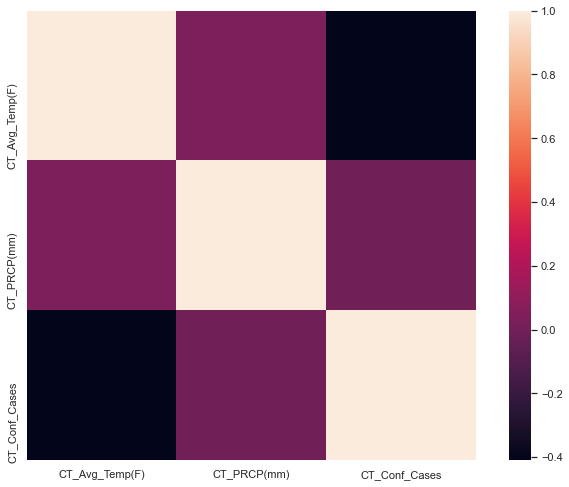

In [103]:
sns.heatmap(Hartford_CT.corr(), square=True, cmap='rocket')

In [104]:
Middlesex_MA = df7[['MA_Avg_Temp(F)', 'MA_PRCP(mm)', 'MA_Conf_Cases']]

<AxesSubplot:>

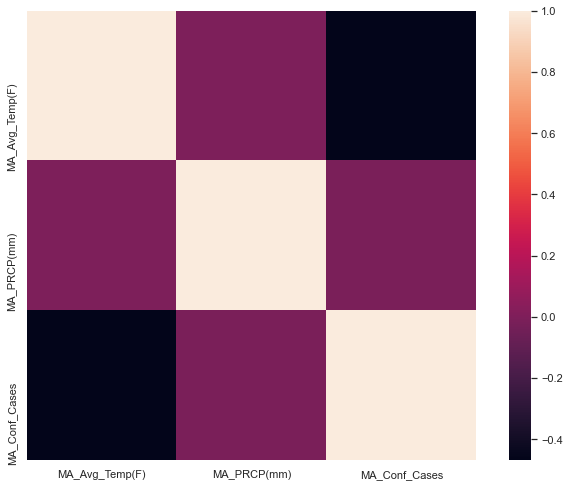

In [105]:
sns.heatmap(Middlesex_MA.corr(), square=True, cmap='rocket')

In [106]:
Essex_VT = df7[['VT_Avg_Temp(F)', 'VT_PRCP(mm)', 'VT_Conf_Cases']]

<AxesSubplot:>

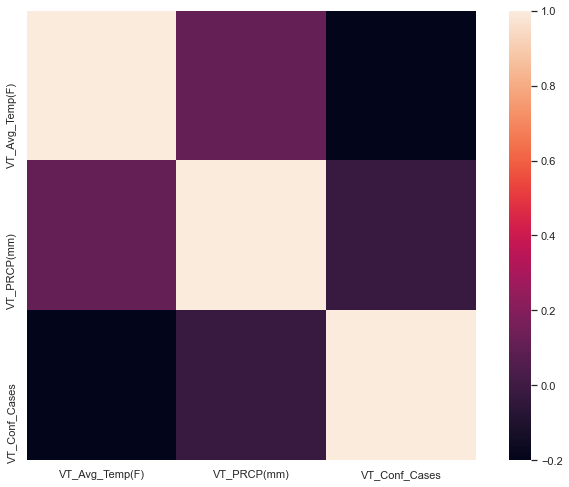

In [107]:
sns.heatmap(Essex_VT.corr(), square=True, cmap='rocket')

In [108]:
Piscataquis_ME = df7[['ME_Avg_Temp(F)', 'ME_PRCP(mm)', 'ME_Conf_Cases']]

<AxesSubplot:>

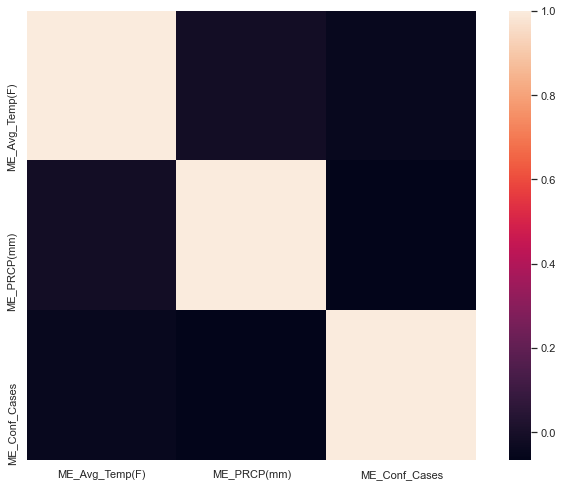

In [109]:
sns.heatmap(Piscataquis_ME.corr(), square=True, cmap='rocket')

In [110]:
# save the data to a new csv file
df7.to_csv('cov_weather.csv')